In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib
from scipy.stats import zscore , mstats
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# 1. Load the dataset
rainfall_data = pd.read_csv("lka-rainfall.csv")

In [3]:
# 2. Convert 'date' column to datetime format
rainfall_data['date'] = pd.to_datetime(rainfall_data['date'])

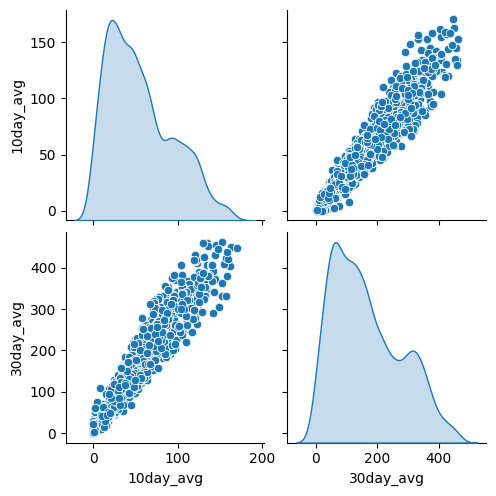

In [70]:
# 4. Visualize the dataset distribution
sns.pairplot(rainfall_data[['10day_avg', '30day_avg', 'Districts', 'Month']], diag_kind='kde', height=2.5)
plt.show()

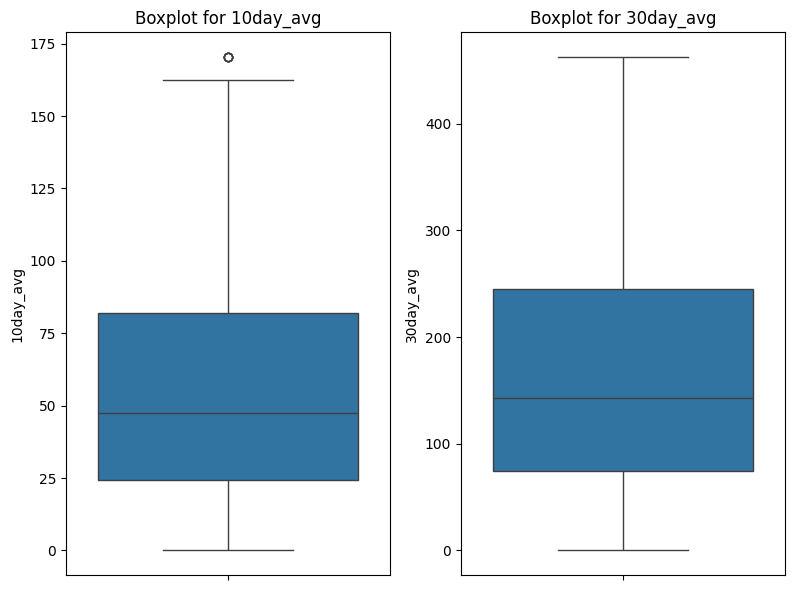

In [ ]:
# 5. Checking for outliers using boxplots
features = ['10day_avg', '30day_avg']
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=rainfall_data[feature])
    plt.title(f'Boxplot for {feature}')
plt.tight_layout()
plt.show()

In [72]:
# Check for missing values in the dataset
missing_values = rainfall_data.isnull().sum()

# Print the number of missing values for each column
print("Missing Values in Each Column:")
print(missing_values)

# Total missing values in the entire dataset
total_missing = missing_values.sum()
print(f"\nTotal Missing Values in the Dataset: {total_missing}")


Missing Values in Each Column:
date         0
Month        0
Districts    0
10day_avg    0
30day_avg    0
dtype: int64

Total Missing Values in the Dataset: 0


In [4]:
# . Check for outliers using z-scores
features = ['10day_avg', '30day_avg']
z_scores = np.abs(zscore(rainfall_data[features]))
outlier_indices = np.where(z_scores > 3)  # Threshold for identifying outliers
print(f"\nNumber of outliers detected: {len(outlier_indices[0])}")

# Get the rows that correspond to the outliers
outliers = rainfall_data.iloc[outlier_indices[0]]

# Display the outliers
print(outliers)



Number of outliers detected: 0
Empty DataFrame
Columns: [date, Month, Districts, 10day_avg, 30day_avg]
Index: []


In [74]:
# 6. Handle outliers by clipping to the 5th and 95th percentiles
for feature in features:
    lower_limit = rainfall_data[feature].quantile(0.05)
    upper_limit = rainfall_data[feature].quantile(0.95)
    rainfall_data[feature] = np.clip(rainfall_data[feature], lower_limit, upper_limit)

In [5]:
# Initialize LabelEncoders
label_encoder_month = LabelEncoder()
label_encoder_district = LabelEncoder()

# Fit and transform encoding
rainfall_data['Month_encoded'] = label_encoder_month.fit_transform(rainfall_data['Month'])
rainfall_data['Districts_encoded'] = label_encoder_district.fit_transform(rainfall_data['Districts'])

# Save the encoders for later use
joblib.dump(label_encoder_month, "Rainfall_encoder_month.pkl")
joblib.dump(label_encoder_district, "Rainfall_encoder_district.pkl")

# 4. Prepare features (X) and target labels (y)
X = rainfall_data[['Districts_encoded', 'Month_encoded']]  # Independent variables (features)
y = rainfall_data['30day_avg']  # Dependent variable (target)

In [6]:
# 8. Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'rainfall_scaler.pkl')

['rainfall_scaler.pkl']

In [7]:
# 9. Split dataset into 70% training and 30% temporary
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 9.1 Further split temporary set into 20% validation and 80% testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)

In [ ]:
# 10. Build the prediction model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

f:\Softwares\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
# 11. Train the model with EarlyStopping
print("Training the rainfall prediction model...")

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=16, callbacks=[early_stopping])


Training the rainfall prediction model...
Epoch 1/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 36031.3086 - mae: 156.6071 - val_loss: 10955.7715 - val_mae: 83.4369
Epoch 2/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11709.2861 - mae: 90.4798 - val_loss: 10667.6963 - val_mae: 83.8844
Epoch 3/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11629.4248 - mae: 90.5824 - val_loss: 10425.3701 - val_mae: 82.2860
Epoch 4/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11012.3008 - mae: 88.0110 - val_loss: 10290.5322 - val_mae: 82.7674
Epoch 5/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11048.2754 - mae: 88.2528 - val_loss: 10153.8574 - val_mae: 82.0820
Epoch 6/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11282.7402 - mae: 89.6902 - val_loss: 10204.5273 - val_mae: 83.6464
Epoch 7/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11369.9902 - mae: 90.3946 - val_loss: 10077.3652 - val_mae: 82.8055
Epoch 8/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

In [80]:
# 12. Save the trained model
model.save('rainfall_prediction_model.h5')
print("Rainfall prediction model saved successfully.")

Rainfall prediction model saved successfully.


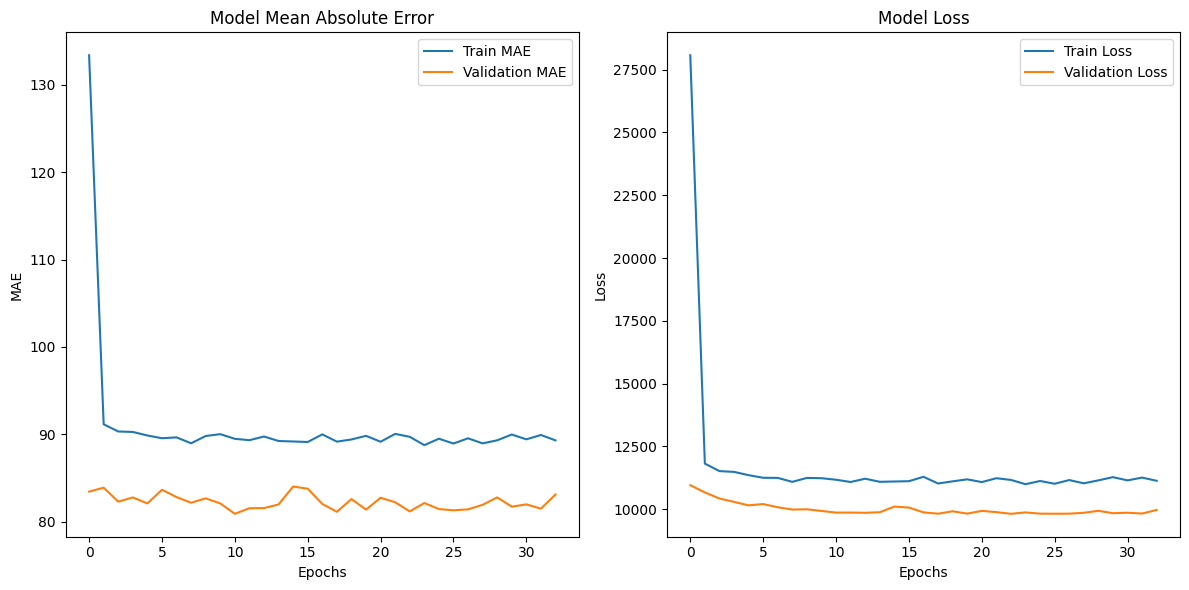

In [81]:
# 13. Visualize training and validation metrics
plt.figure(figsize=(12, 6))

# Plot MAE
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [85]:
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

# Load the trained model
model = load_model("rainfall_prediction_model.h5", custom_objects={"mse": MeanSquaredError()})

# Load the saved encoders
label_encoder_month = joblib.load("Rainfall_encoder_month.pkl")
label_encoder_district = joblib.load("Rainfall_encoder_district.pkl")

# Example test data
new_data = {
    "Month": "April",
    "District": "Kilinochchi"
}

# Encode categorical values
month_encoded = label_encoder_month.transform([new_data["Month"]])[0]
district_encoded = label_encoder_district.transform([new_data["District"]])[0]

# Prepare feature array
features = np.array([[district_encoded,month_encoded,]])

# ✅ Correct the shape (model expects (None, 2), so reshape to (1, 2))
features_reshaped = features.reshape(1, 2)

# Make prediction
predicted_rainfall = model.predict(features_reshaped)

print(f"Predicted Rainfall (mm): {predicted_rainfall[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Predicted Rainfall (mm): 166.67323303222656


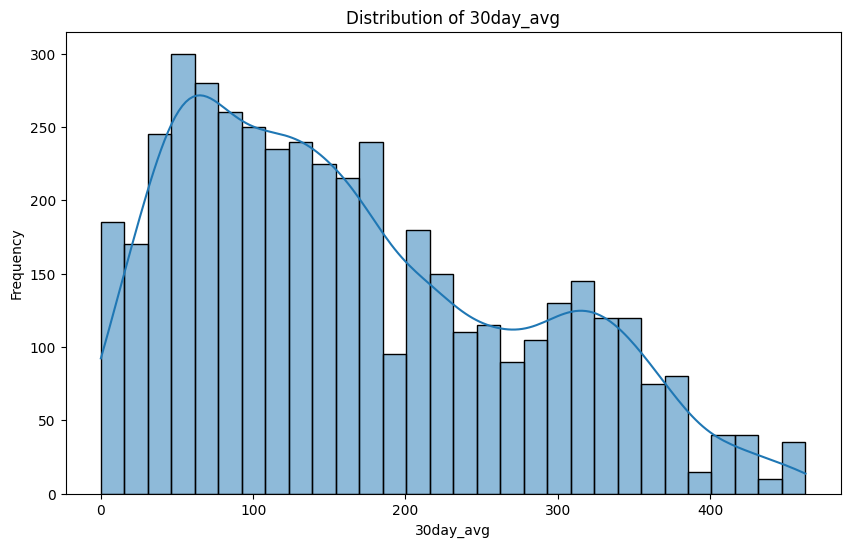

In [9]:
# Visualize the distribution of the target variable (Storage %)
plt.figure(figsize=(10, 6))
sns.histplot(rainfall_data['30day_avg'], kde=True, bins=30)
plt.title('Distribution of 30day_avg')
plt.xlabel('30day_avg')
plt.ylabel('Frequency')
plt.show()

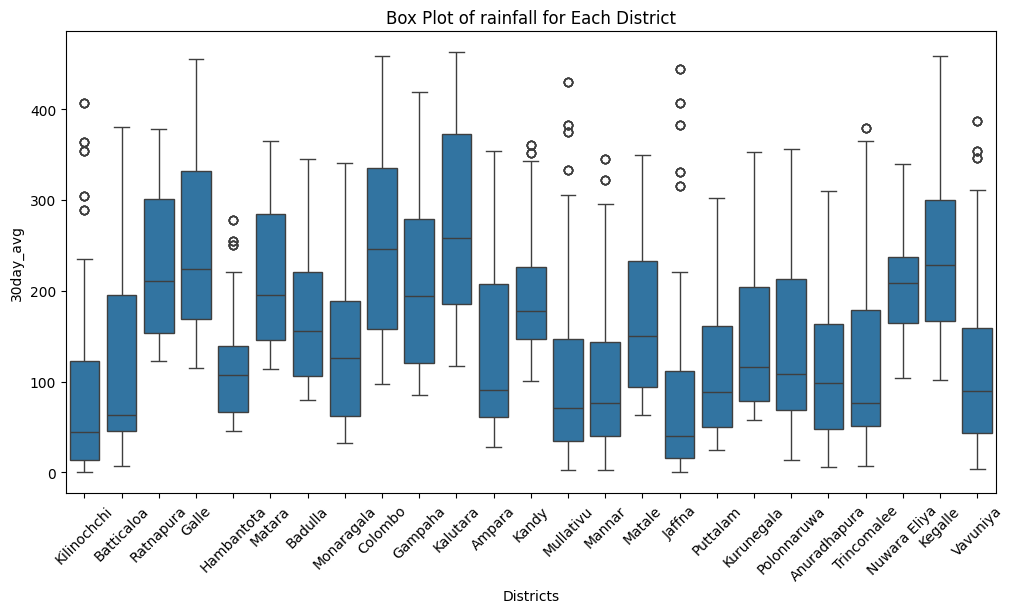

In [10]:
plt.figure(figsize=(12, 6))  # Increase figure size if needed
sns.boxplot(x='Districts', y='30day_avg', data=rainfall_data)
plt.title('Box Plot of rainfall for Each District')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()

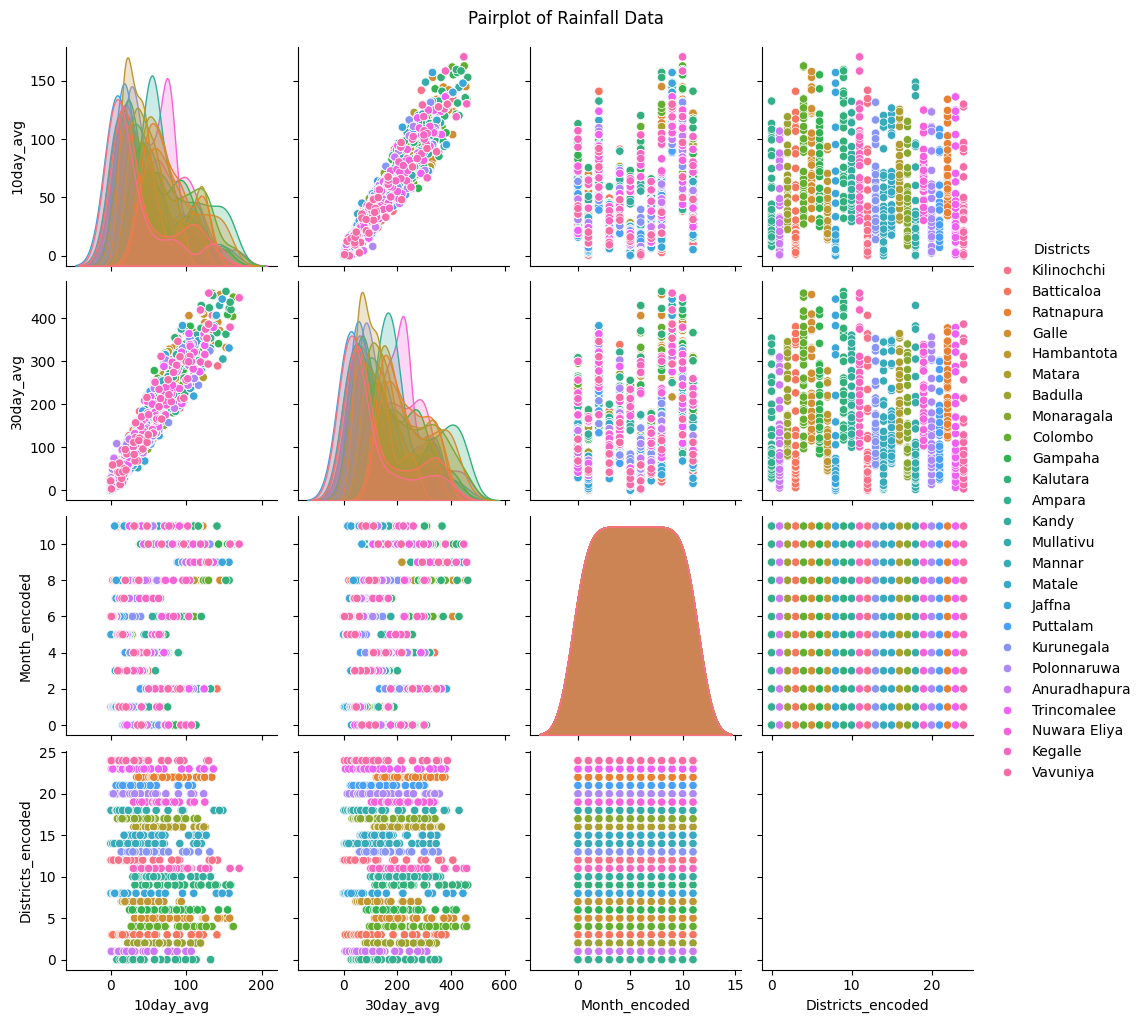

In [11]:
sns.pairplot(rainfall_data, hue='Districts')
plt.suptitle('Pairplot of Rainfall Data', y=1.02)
plt.show()

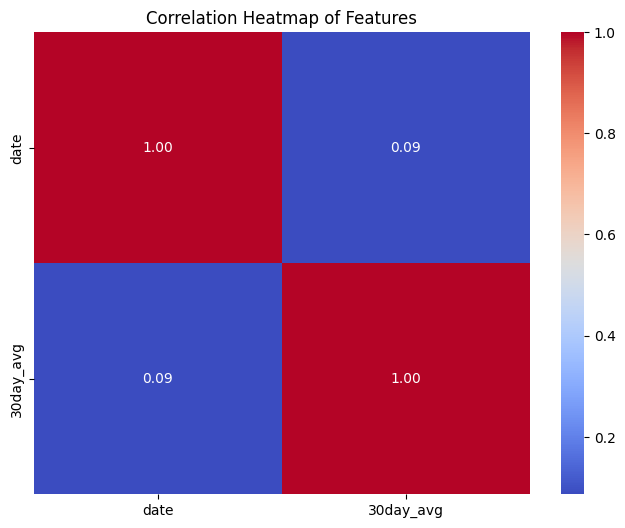

In [12]:
corr = rainfall_data[['date', '30day_avg']].corr()  # Remove 'Range'
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()